In [1]:
import numpy as np
import tensorflow as tf
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import log_loss
from keras.optimizers import SGD
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

Using TensorFlow backend.


In [2]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [3]:
x_train = np.load("datasets/normal/x_train_200.npy")
y_train = np.load("datasets/normal/y_train_200.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [4]:
x_val = np.load("datasets/normal/x_val_200.npy")
y_val = np.load("datasets/normal/y_val_200.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [5]:
x_test = np.load("datasets/normal/x_test_200.npy")
y_test = np.load("datasets/normal/y_test_200.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [6]:
img = x_train[50]
img.shape

(200, 200, 3)

In [7]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [8]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [9]:
def get_model_exp2_b():
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    #extract feature from the optimal layer for your data
    base_model = Model(input=base_model.input, output=base_model.get_layer('block5_conv2').output)         
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax', name='predictions')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional layers to prevent large gradient updates wrecking the learned weights
    for layer in base_model.layers:
        layer.trainable = False

    #fix the optimizer
    sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) 

    #compile the model
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall, f1, matthews_correlation, auc])

    return model

model = None
model=get_model_exp2_b()
model.summary()

C:\Users\User\Anaconda3\envs\malaria\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [10]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [11]:
model=get_model_exp2_b()
path_model='raja_1.h5'  

# set the learning rate
#K.set_value(model.optimizer.lr, 0.01) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=32, 
            epochs=100, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            )

C:\Users\User\Anaconda3\envs\malaria\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  """


Train on 22046 samples, validate on 2756 samples
Epoch 1/100
22046/22046 [==============================] - 134s 6ms/step - loss: 1.7473 - acc: 0.7754 - precision: 0.7775 - recall: 0.7776 - f1: 0.7712 - matthews_correlation: 0.5515 - auc: 0.7080 - val_loss: 0.3099 - val_acc: 0.9405 - val_precision: 0.9704 - val_recall: 0.9065 - val_f1: 0.9351 - val_matthews_correlation: 0.8808 - val_auc: 0.8293
Epoch 2/100
22046/22046 [==============================] - 131s 6ms/step - loss: 0.6402 - acc: 0.8913 - precision: 0.8924 - recall: 0.8908 - f1: 0.8884 - matthews_correlation: 0.7822 - auc: 0.8654 - val_loss: 0.2322 - val_acc: 0.9525 - val_precision: 0.9594 - val_recall: 0.9426 - val_f1: 0.9497 - val_matthews_correlation: 0.9036 - val_auc: 0.8878
Epoch 3/100
22046/22046 [==============================] - 130s 6ms/step - loss: 0.4467 - acc: 0.9084 - precision: 0.9091 - recall: 0.9079 - f1: 0.9054 - matthews_correlation: 0.8172 - auc: 0.9005 - val_loss: 0.1965 - val_acc: 0.9539 - val_precision: 0.

22046/22046 [==============================] - 130s 6ms/step - loss: 0.1654 - acc: 0.9445 - precision: 0.9478 - recall: 0.9406 - f1: 0.9426 - matthews_correlation: 0.8885 - auc: 0.9649 - val_loss: 0.1320 - val_acc: 0.9557 - val_precision: 0.9648 - val_recall: 0.9452 - val_f1: 0.9536 - val_matthews_correlation: 0.9105 - val_auc: 0.9652
Epoch 24/100
22046/22046 [==============================] - 130s 6ms/step - loss: 0.1645 - acc: 0.9441 - precision: 0.9482 - recall: 0.9408 - f1: 0.9429 - matthews_correlation: 0.8880 - auc: 0.9656 - val_loss: 0.1327 - val_acc: 0.9557 - val_precision: 0.9672 - val_recall: 0.9432 - val_f1: 0.9538 - val_matthews_correlation: 0.9106 - val_auc: 0.9659
Epoch 25/100
22046/22046 [==============================] - 130s 6ms/step - loss: 0.1634 - acc: 0.9443 - precision: 0.9471 - recall: 0.9411 - f1: 0.9423 - matthews_correlation: 0.8886 - auc: 0.9662 - val_loss: 0.1298 - val_acc: 0.9546 - val_precision: 0.9612 - val_recall: 0.9466 - val_f1: 0.9526 - val_matthews_c

22046/22046 [==============================] - 131s 6ms/step - loss: 0.1497 - acc: 0.9484 - precision: 0.9531 - recall: 0.9434 - f1: 0.9464 - matthews_correlation: 0.8974 - auc: 0.9742 - val_loss: 0.1272 - val_acc: 0.9543 - val_precision: 0.9528 - val_recall: 0.9539 - val_f1: 0.9520 - val_matthews_correlation: 0.9079 - val_auc: 0.9743
Epoch 47/100
22046/22046 [==============================] - 132s 6ms/step - loss: 0.1501 - acc: 0.9486 - precision: 0.9523 - recall: 0.9455 - f1: 0.9471 - matthews_correlation: 0.8975 - auc: 0.9744 - val_loss: 0.1259 - val_acc: 0.9575 - val_precision: 0.9637 - val_recall: 0.9502 - val_f1: 0.9557 - val_matthews_correlation: 0.9140 - val_auc: 0.9745
Epoch 48/100
22046/22046 [==============================] - 132s 6ms/step - loss: 0.1508 - acc: 0.9496 - precision: 0.9536 - recall: 0.9460 - f1: 0.9482 - matthews_correlation: 0.8991 - auc: 0.9746 - val_loss: 0.1309 - val_acc: 0.9550 - val_precision: 0.9716 - val_recall: 0.9356 - val_f1: 0.9519 - val_matthews_c

22046/22046 [==============================] - 130s 6ms/step - loss: 0.1384 - acc: 0.9516 - precision: 0.9547 - recall: 0.9489 - f1: 0.9502 - matthews_correlation: 0.9033 - auc: 0.9782 - val_loss: 0.1238 - val_acc: 0.9590 - val_precision: 0.9676 - val_recall: 0.9484 - val_f1: 0.9568 - val_matthews_correlation: 0.9170 - val_auc: 0.9783
Epoch 70/100
22046/22046 [==============================] - 130s 6ms/step - loss: 0.1360 - acc: 0.9524 - precision: 0.9570 - recall: 0.9475 - f1: 0.9505 - matthews_correlation: 0.9046 - auc: 0.9784 - val_loss: 0.1229 - val_acc: 0.9583 - val_precision: 0.9630 - val_recall: 0.9518 - val_f1: 0.9561 - val_matthews_correlation: 0.9158 - val_auc: 0.9784
Epoch 71/100
22046/22046 [==============================] - 130s 6ms/step - loss: 0.1364 - acc: 0.9518 - precision: 0.9551 - recall: 0.9488 - f1: 0.9504 - matthews_correlation: 0.9033 - auc: 0.9785 - val_loss: 0.1228 - val_acc: 0.9579 - val_precision: 0.9663 - val_recall: 0.9480 - val_f1: 0.9560 - val_matthews_c

22046/22046 [==============================] - 129s 6ms/step - loss: 0.1312 - acc: 0.9558 - precision: 0.9590 - recall: 0.9521 - f1: 0.9542 - matthews_correlation: 0.9113 - auc: 0.9806 - val_loss: 0.1226 - val_acc: 0.9583 - val_precision: 0.9671 - val_recall: 0.9478 - val_f1: 0.9562 - val_matthews_correlation: 0.9157 - val_auc: 0.9807
Epoch 93/100
22046/22046 [==============================] - 130s 6ms/step - loss: 0.1339 - acc: 0.9525 - precision: 0.9563 - recall: 0.9494 - f1: 0.9515 - matthews_correlation: 0.9051 - auc: 0.9807 - val_loss: 0.1208 - val_acc: 0.9601 - val_precision: 0.9623 - val_recall: 0.9559 - val_f1: 0.9580 - val_matthews_correlation: 0.9191 - val_auc: 0.9808
Epoch 94/100
22046/22046 [==============================] - 130s 6ms/step - loss: 0.1283 - acc: 0.9549 - precision: 0.9584 - recall: 0.9516 - f1: 0.9536 - matthews_correlation: 0.9099 - auc: 0.9808 - val_loss: 0.1219 - val_acc: 0.9597 - val_precision: 0.9663 - val_recall: 0.9515 - val_f1: 0.9577 - val_matthews_c

In [12]:
model.save(path_model)

In [13]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('raja_exp1_loss.jpg', dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('raja_exp1_acc.jpg', dpi=300)
    plt.show()

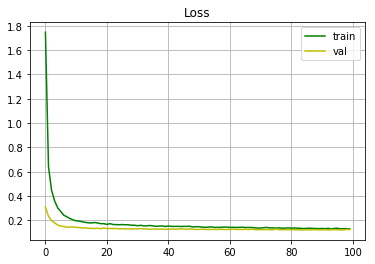

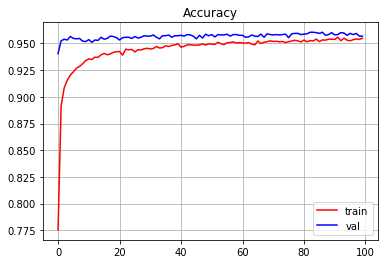

Done!


In [14]:
plot_loss_accu(model.history)
plot_loss(model.history)
print("Done!")

In [15]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 14s 5ms/step
Test loss: 0.11443580676097266
Test accuracy: 0.9615384615384616


In [16]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])

#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [17]:
y_pred.shape

(2756, 2)

In [18]:
accuracy

0.9615384615384616

In [19]:
np.save("y_pred_raja_exp1.npy", y_pred)